In [16]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import namedtuple, Counter
from random import shuffle
import pickle
import pandas as pd
import multiprocessing
import time
import numpy as np
import re
import random
import matplotlib.pyplot as plt


%matplotlib inline

numcores = multiprocessing.cpu_count()
numcores = 3

In [17]:
model = Doc2Vec.load('data/model-week4b')

# Step 1: t-SNE

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
dvv = []

for i in range(model.corpus_count):
    dvv.append(model.docvecs[i])

dvv = pd.DataFrame(dvv)

In [20]:
dvv_scale = StandardScaler().fit_transform(dvv)

In [21]:
dvv_pca = PCA(n_components=30).fit(dvv_scale)

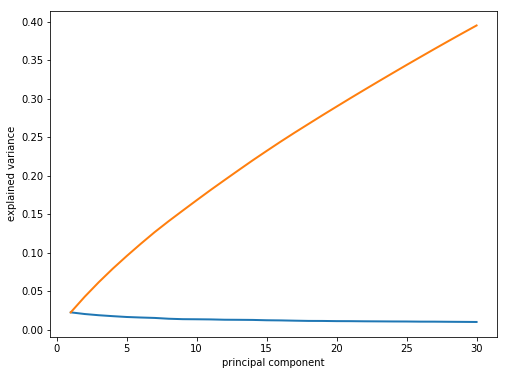

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, dvv_pca.n_components_+1)
ax.plot(x_values, dvv_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(dvv_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')

ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

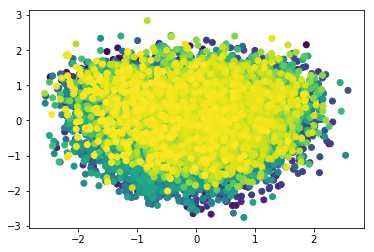

In [24]:
plt.scatter(dvv_pca.fit_transform(dvv)[:,0],dvv_pca.fit_transform(dvv)[:,1], c=np.arange(model.corpus_count), cmap='viridis')

plt.show()

In [25]:
import time

from sklearn.manifold import TSNE

In [26]:
print('Cumulative explained variation for 30 principal components: {}'.format(np.sum(dvv_pca.explained_variance_ratio_)))

Cumulative explained variation for 30 principal components: 0.39721784839309066


In [27]:
n_sne = 1000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(dvv_pca.fit_transform(dvv))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14115 samples in 0.021s...
[t-SNE] Computed neighbors for 14115 samples in 11.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14115
[t-SNE] Computed conditional probabilities for sample 2000 / 14115
[t-SNE] Computed conditional probabilities for sample 3000 / 14115
[t-SNE] Computed conditional probabilities for sample 4000 / 14115
[t-SNE] Computed conditional probabilities for sample 5000 / 14115
[t-SNE] Computed conditional probabilities for sample 6000 / 14115
[t-SNE] Computed conditional probabilities for sample 7000 / 14115
[t-SNE] Computed conditional probabilities for sample 8000 / 14115
[t-SNE] Computed conditional probabilities for sample 9000 / 14115
[t-SNE] Computed conditional probabilities for sample 10000 / 14115
[t-SNE] Computed conditional probabilities for sample 11000 / 14115
[t-SNE] Computed conditional probabilities for sample 12000 / 14115
[t-SNE] Computed conditional probabilities for s

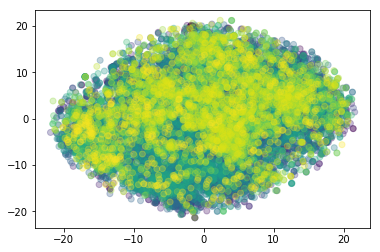

In [28]:
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], alpha=0.3, c=np.arange(model.corpus_count), cmap='viridis')
plt.show()

# Step 2: Duplicates

In [3]:
from scipy import stats

In [4]:
aotable = pickle.load(open('data/AOmasterdata-nodup-week4b', 'rb'))

aotable.head(3)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,wierdness,weirdpct_x,weirdness,weirdpct_y
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.145993,43.89,0.145993,43.89
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.154920,12.74,0.154920,12.74
2,596,The Haunted Bookshop,"Occult books, Tarot, Oddities.",Melbourne,Australia,"Melbourne, Australia",https://www.atlasobscura.com/places/haunted-bo...,,-37.815472,144.961689,"repositories of knowledge,occult,bookstores",The creepy Haunted Bookshop in Melbourne is lo...,https://assets.atlasobscura.com/media/W1siZiIs...,"Occult books, Tarot, Oddities.The creepy Haunt...","occult books , tarot , oddities the creepy h...","[occult, books, tarot, oddities, the, creepy, ...",0.137951,77.70,0.137951,77.70


In [5]:
duplicates = list(aotable[aotable.duplicated('title', keep=False)]['title'].unique())

testdf = []
for i in duplicates:
    tmp = {'name': i,
          'id1': list(aotable[aotable['title'] == i]['id'].values)[0],
          'id2': list(aotable[aotable['title'] == i]['id'].values)[1]}
    testdf.append(tmp)

dups = pd.DataFrame(testdf)
dups.head(5)

,id1,id2,name
0,5875,16876,The Pinnacles
1,18896,17531,Cube House
2,2731,5738,Old Country Market
3,4513,698,Mountain View Cemetery
4,18344,3023,Old Burying Ground


In [6]:
# Find the similarities between all pairs of duplicates
pairsims = []
for index,row in dups.iterrows():
    pairsims.append(model.docvecs.similarity(str(row['id1']),str(row['id2'])))

dups['pairsim'] = pairsims

In [7]:
# for each row, get the distance to a random sample 
boot_t = []
boot_p = []

for si in range(1000):
    bootsample = []

    for i in range(len(dups)):
        randcol = random.choice(['id1','id2'])
        idofsample = str(dups[randcol].iloc[i])

        # randomly sample any other id
        tocompare = str(random.choice(aotable['id']))
        while tocompare == str(dups['id1'].iloc[i]) or tocompare == str(dups['id1'].iloc[i]):
            tocompare = str(random.choice(aotable['id']))

        # compare with random sample and add to vector
        bootsample.append(model.docvecs.similarity(idofsample, tocompare))

    tval, pval = stats.ttest_rel(dups['pairsim'],bootsample)

    boot_t.append(tval)
    boot_p.append(pval)

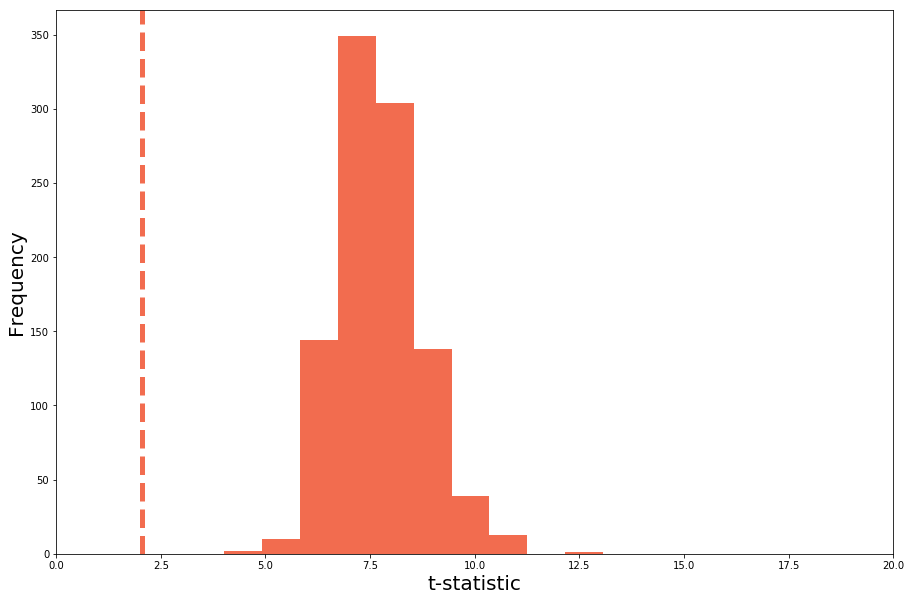

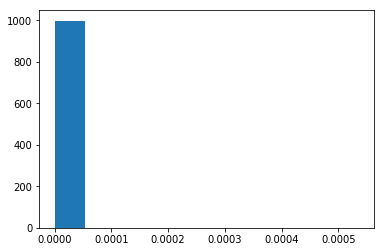

In [38]:
plt.figure(figsize=(15, 10))
plt.hist(boot_t, color='#f26c4fff')
plt.xlim(0,20)
plt.axvline(x=2.06, linestyle='--', linewidth=5, color='#f26c4fff')
plt.xlabel('t-statistic', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tight_layout()
plt.savefig('fig/VAL_duplicates.jpg', format='jpg', dpi=300)
plt.show()

plt.hist(boot_p, 10)
plt.show()

# Step 3: matching keywords

In [9]:
aotable.head(2)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,wierdness,weirdpct_x,weirdness,weirdpct_y
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.145993,43.89,0.145993,43.89
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.154920,12.74,0.154920,12.74


In [10]:
aotable['splitkeys'] = [x.split(',') for x in aotable['keywords']]



In [11]:
# get a table of all keywords

megastring = ','.join(list(aotable['keywords']))

keys = megastring.split(",")

keystable = pd.DataFrame(Counter(keys), index=['count']).T.reset_index().rename(columns={'index':'keyword'})

keystable = keystable.sort_values(by='count', ascending=True).reset_index(drop=True).drop(0)

len(keystable)

2278

In [12]:
# Get only keywords with more than 3 matches
keystable = keystable[keystable['count'] > 2].reset_index(drop=True)
keystable = keystable[keystable['keyword'] != ''].reset_index(drop=True)
len(keystable)

1390

In [13]:
keystable.head(2)

,keyword,count
0,rituals (internal),3
1,astronauts,3


In [14]:
key_t = []
key_p = []

for j in range(1000):
    simgroup = []
    outgroup = []
    
    for i in range(30):
        # get a random keyword
        randkey = random.choice(keystable['keyword'])

        # subset table to include only locations that have the keyword
        tablematch = aotable[[randkey in x for x in aotable['keywords']]]
        tablenotmatch = aotable[[randkey not in x for x in aotable['keywords']]]

        # choose 2 from the matching table
        twomatching = [str(x) for x in random.sample(list(tablematch['id']),2)]

        # choose 1 from the non-matching table
        onenotmatching = str(random.choice(list(tablenotmatch['id'])))

        simgroup.append(model.docvecs.similarity(twomatching[0], twomatching[1])) 
        outgroup.append(model.docvecs.similarity(twomatching[0], onenotmatching))

    tval, pval = stats.ttest_rel(simgroup, outgroup)

    key_t.append(tval)
    key_p.append(pval)

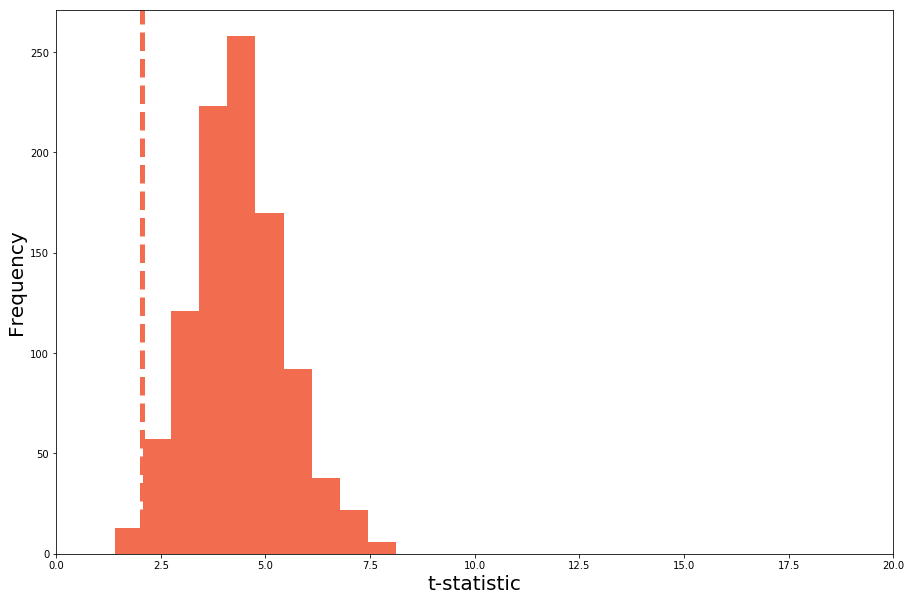

In [39]:
plt.figure(figsize=(15, 10))
plt.hist(key_t, color='#f26c4fff')
plt.xlim(0,20)
plt.axvline(x=2.06, linestyle='--', linewidth=5, color='#f26c4fff')
plt.xlabel('t-statistic', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tight_layout()
plt.savefig('fig/VAL_keyword.jpg', format='jpg', dpi=300)
plt.show()